In [2]:
import sys
import math
sys.path.insert(0, r'/home/danis/work/python_works/gamma_4/Scripts')
sys.path.insert(0, r'D:\Учеба\Практика\Диплом\gamma_4\Scripts')
import numpy as np
import pandas as pd
from materials import*
import matplotlib.pyplot as plt

Минимальная энергия: 1e-3
windows (w) or linux (l): l


In [4]:
# Параметры пучка электронов и мишени
target = R(Material(50), 1e-2)
beams_energy = 0.075
brem = target.brem(beams_energy)
brem_e = brem * en

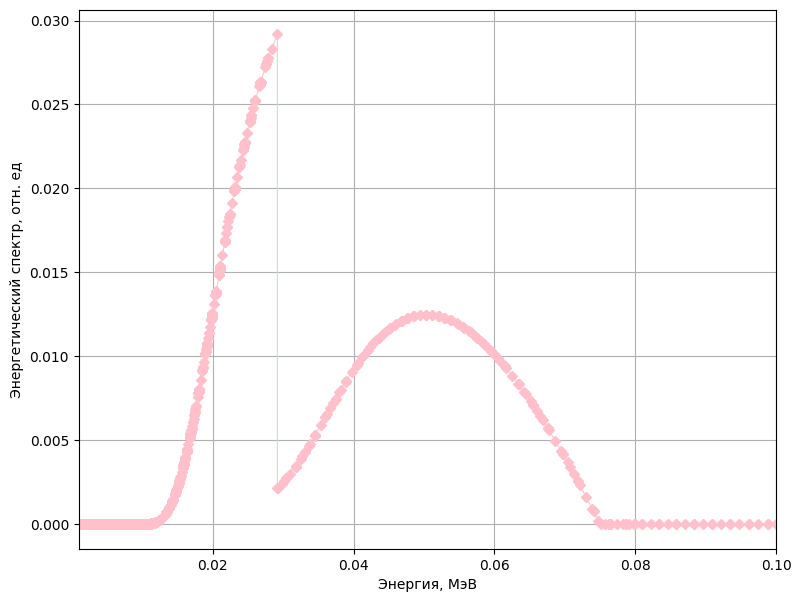

In [5]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(en, brem_e, ls='-', marker='D', lw='0.7', ms=5, color='pink')

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.10e0)
# ax.set_ylim(1e-7, 1.2)

ax.grid(True)

# fig.savefig('Тормозной спектр.jpg', bbox_inches='tight')

In [6]:
n = 11

In [7]:
# Индексы К скачков
EDGE = []
for i in range(1, len(en)):
    if en[i - 1] == en[i]:
        EDGE.append(i - 1)

In [12]:
EDGE.remove(EDGE[EDGE.index(Material(50).k_index())])

Спектральные характеристики чувствительности каналов

In [13]:
edge_thiknesses = [Material(i).lt(0.75) for i in range(n, 101)]
edge_regions = [R(Material(i+n), edge_thiknesses[i]) for i in range(0, len(edge_thiknesses))]
resp_edges = [val.f() for val in edge_regions]

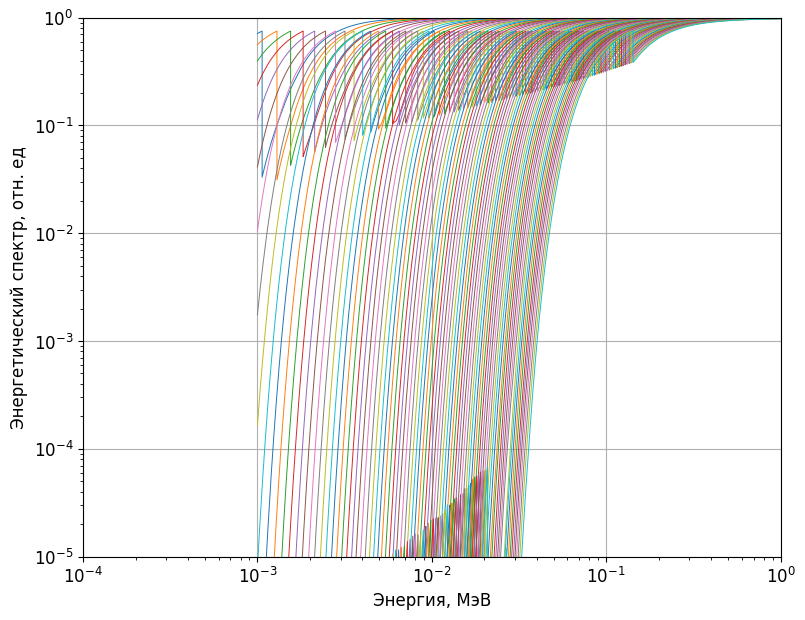

In [14]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in resp_edges:
    ax.plot(en, i, ls='-', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Пропускание, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-4, 1e0)
ax.set_ylim(1e-5, 1e0)
ax.grid(True)

Сигналы детекторов

In [15]:
from garipov_deconvolution import get_coeff_simpson

In [16]:
signals_simpson = []

for response in resp_edges:
    signals_simpson.append(sum(get_coeff_simpson(response*brem_e, en, EDGE)[0]))

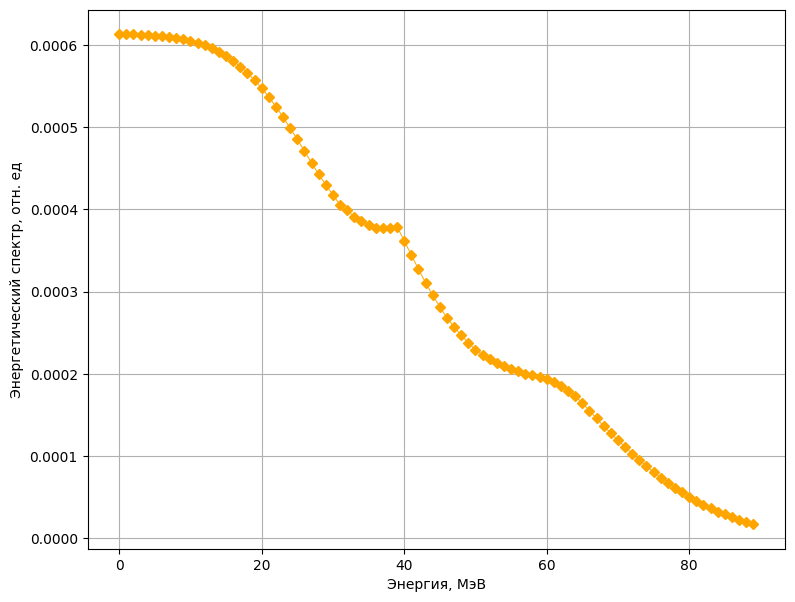

In [22]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(list(range(len(signals_simpson))), signals_simpson, ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1.e-5, 0.3e-4)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)

Матрица задачи

In [23]:
Matrixs = []

for response in resp_edges:
    Matrixs.append(get_coeff_simpson(response, en, EDGE)[0])

In [24]:
from garipov_deconvolution import*

In [20]:
sp = [0 for i in range(len(signals_simpson))]
norm = [0 for i in range(len(signals_simpson))]
decb = [0 for i in range(len(signals_simpson))]
dev = [0 for i in range(len(signals_simpson))]

new_en = get_coeff_simpson(resp_edges[0], en, EDGE)[1]

In [21]:
import time

start_time = time.time()
sp, norm, dev = Gold(Matrixs, signals_simpson, en, brem_e, new_en, 1, 100000, w=True, d=False)[:3]
print(f'время: {time.time() - start_time}, секунд')

время: 35.806907176971436, секунд


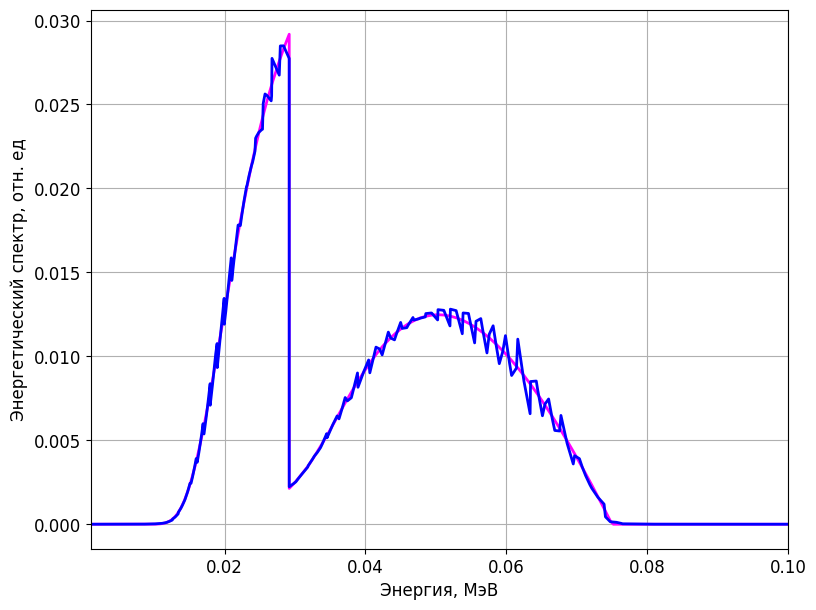

In [25]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(en, brem_e, ls='-', lw='2', ms=5, color='magenta')
ax.plot(new_en, sp, ls='-', lw='2', ms=5, color='blue')


# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)

In [26]:
dev

0.03864047913544602